In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torcheval
from torcheval.metrics.functional import multiclass_f1_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import sklearn
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import time

#### **Some Setup**

In [2]:
genres = [f for f in os.listdir('Data/images_3sec')]

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
batch_size = 128
num_epochs = 50

In [5]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                ])

#### **Loading dataset and checking image size and labels**

In [6]:
dataset = datasets.ImageFolder(root='Data/images_3sec', transform=transform)

In [7]:
image, label = dataset[0]

In [8]:
image.shape

torch.Size([3, 128, 128])

In [9]:
unique_labels = set(dataset.targets)
unique_labels

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

#### **Splitting dataset into training, testing, and validation datasets (70-15-15 split)**

In [10]:
labels = dataset.targets

In [11]:
train_indices, test_val_indices = model_selection.train_test_split(range(len(labels)), train_size=0.7, random_state=17, stratify=labels)
test_val_labels = [labels[idx] for idx in test_val_indices]
test_indices, val_indices = model_selection.train_test_split(test_val_indices, train_size=0.5, random_state=33, stratify=test_val_labels)

In [12]:
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### **Model 1**

#### **Defining the CNN**

In [14]:
class GenreClassifier(nn.Module):

    def __init__(self):
        #input image dim: 3 x 128 x 128
        super(GenreClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(num_features=8)
        self.pool = nn.MaxPool2d(2, 2) # 8 x 64 x 64
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(num_features=16)
        #pool: 16 x 32 x 32
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm3 = nn.BatchNorm2d(num_features=32)
        #pool: 32 x 16 x 16
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm4 = nn.BatchNorm2d(num_features=64)
        #pool: 64 x 8 x 8
        self.dropout = nn.Dropout(0.2)
        #Fully connected layers
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.norm1(self.conv1(x)), negative_slope=0.2)) #Convolution Block 1
        x = self.pool(F.leaky_relu(self.norm2(self.conv2(x)), negative_slope=0.2)) #Convolution Block 2
        x = self.pool(F.leaky_relu(self.norm3(self.conv3(x)), negative_slope=0.2)) #Convolution Block 3
        x = self.pool(F.leaky_relu(self.norm4(self.conv4(x)), negative_slope=0.2)) # Convolution Block 4
        x = torch.flatten(x, 1)
        x = self.dropout(x) #Dropout to reduce overfiting
        x = F.relu(self.fc1(x)) #Fully Connected Layer 1
        x = F.relu(self.fc2(x)) #Fully Connected Layer 2
        x = self.fc3(x) #Fully Connected Layer 3- 10 neurons, each one will predict probability of input belonging to a class
        return x

In [15]:
#Model + hyperparamters
num_epochs = 50
lr = 1e-3
model = GenreClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [16]:
model.train()

GenreClassifier(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [17]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

In [18]:
for i in range(num_epochs):
    print(f"Training EPOCH {i+1}/{num_epochs}...")
    start = time.time()

    epoch_train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        output = model(data)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    end1 = time.time()

    model.eval()
    train_correct, train_samples, val_correct, val_samples = 0, 0, 0, 0
    epoch_val_loss = 0
    
    with torch.no_grad():
        for (data, targets) in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            train_output = model(data)
            _, predictions = train_output.max(1)
            train_correct += (predictions == targets).sum()
            train_samples += len(targets)

        for (data, targets) in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            val_output = model(data)
            _, predictions = val_output.max(1)
            val_correct += (predictions == targets).sum()
            val_samples += len(targets)

            loss = criterion(val_output, targets)
            epoch_val_loss += loss.item()       

    model.train()

    end2 = time.time()
    
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)

    train_acc = (train_correct / train_samples) * 100
    val_acc = (val_correct / val_samples) * 100

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    print(f"EPOCH {i+1}/{num_epochs}: Training Loss={train_loss:.4f}, Validation Loss={val_loss:0.4f}, Training Accuracy={train_acc:0.2f}%, Validation Accuracy={val_acc:0.2f}%")
    print(f"EPOCH {i+1}/ {num_epochs}: Training time={(end1-start) / 60:0.2f} minutes, Accuracy Check Time={(end2-end1) / 60:0.2f} minutes")
    print(f"\n")

Training EPOCH 1/50...
EPOCH 1/50: Training Loss=1.4909, Validation Loss=1.3401, Training Accuracy=50.72%, Validation Accuracy=50.97%
EPOCH 1/ 50: Training time=0.37 minutes, Accuracy Check Time=0.30 minutes


Training EPOCH 2/50...
EPOCH 2/50: Training Loss=0.9783, Validation Loss=0.8578, Training Accuracy=73.60%, Validation Accuracy=70.38%
EPOCH 2/ 50: Training time=0.28 minutes, Accuracy Check Time=0.28 minutes


Training EPOCH 3/50...
EPOCH 3/50: Training Loss=0.7437, Validation Loss=0.7351, Training Accuracy=79.68%, Validation Accuracy=74.38%
EPOCH 3/ 50: Training time=0.29 minutes, Accuracy Check Time=0.27 minutes


Training EPOCH 4/50...
EPOCH 4/50: Training Loss=0.5828, Validation Loss=0.7049, Training Accuracy=82.27%, Validation Accuracy=76.18%
EPOCH 4/ 50: Training time=0.28 minutes, Accuracy Check Time=0.27 minutes


Training EPOCH 5/50...
EPOCH 5/50: Training Loss=0.4764, Validation Loss=0.6744, Training Accuracy=83.45%, Validation Accuracy=75.85%
EPOCH 5/ 50: Training time

#### **Plotting graphs for loss and model accuracy (Training & Validation Datasets)**

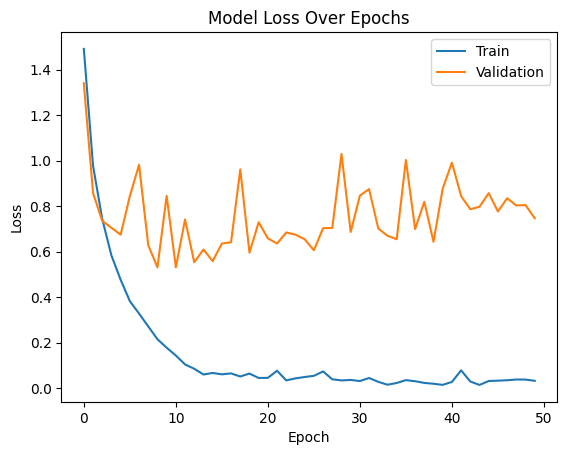

In [19]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title("Model Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

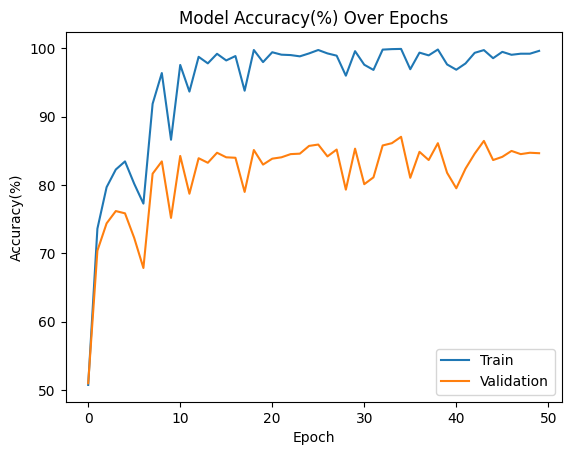

In [20]:
training_accuracy = [x.to(device='cpu') for x in training_accuracy]
validation_accuracy = [x.to(device='cpu') for x in validation_accuracy]
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy(%) Over Epochs")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

#### **Accuracy, F1 Score, and Confusion Matrix to evaluate performance on Test Dataset**

In [21]:
model.eval()
test_correct, test_samples = 0, 0
    
with torch.no_grad():
    for (data, targets) in test_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
            
        test_output = model(data)
        _, predictions = test_output.max(1)
        test_correct += (predictions == targets).sum()
        test_samples += len(targets)
model.train()

test_acc = (test_correct / test_samples) * 100
print(f"Test Accuracy: {test_acc:0.2f}%")

Test Accuracy: 84.58%


In [22]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        f1_predictions = model(data)
        f1_micro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='micro')
        f1_macro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='macro')
        f1_weighted = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='weighted')

        print(f"F1 Score (Micro): {f1_micro:0.4f}")
        print(f"F1 Score (Macro): {f1_macro:0.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:0.4f}")
        torch.cuda.empty_cache() 
    model.train()
m=0

F1 Score (Micro): 0.8458
F1 Score (Macro): 0.8419
F1 Score (Weighted): 0.8418


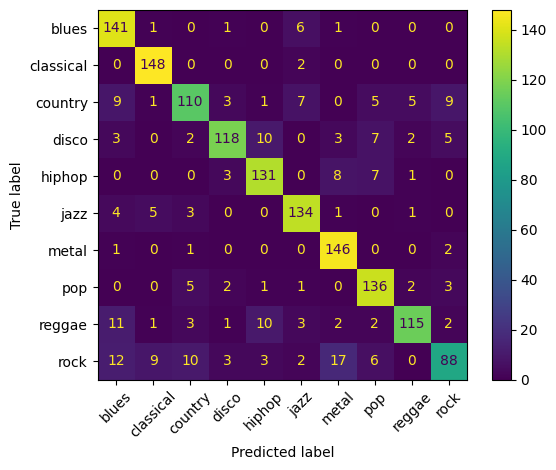

In [23]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        test_output = model(data)
        _, test_preds = test_output.max(1)

        cm = confusion_matrix(labels.to(device='cpu'), test_preds.to(device='cpu'))
        ConfusionMatrixDisplay(cm, display_labels=genres).plot()
        plt.xticks(rotation=45)
        torch.cuda.empty_cache() 
    model.train()
m=0

### **Model 2**

#### **Defining the CNN**

In [24]:
class GenreClassifier2(nn.Module):

    def __init__(self):
        #input image dim: 3 x 128 x 128
        super(GenreClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(num_features=8)
        self.pool = nn.MaxPool2d(2, 2) # 8 x 64 x 64
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(num_features=16)
        #pool: 16 x 32 x 32
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm3 = nn.BatchNorm2d(num_features=32)
        #pool: 32 x 16 x 16
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm4 = nn.BatchNorm2d(num_features=64)
        #pool: 64 x 8 x 8
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.8)
        #Fully connected layers
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.fc4 = nn.Linear(64*8*8, 10)
        self.fc5 = nn.Linear(32*16*16, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.norm1(self.conv1(x)), negative_slope=1e-2)) #Convolution Block 1
        #x = self.dropout1(x)
        x = self.pool(F.leaky_relu(self.norm2(self.conv2(x)), negative_slope=1e-2)) #Convolution Block 2
        #x = self.dropout1(x)
        x = self.pool(F.leaky_relu(self.norm3(self.conv3(x)), negative_slope=1e-2)) #Convolution Block 3
        #x = self.dropout1(x)
        #x = self.pool(F.leaky_relu(self.norm4(self.conv4(x)), negative_slope=1e-2)) # Convolution Block 4
        #x = torch.flatten(x, 1)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout4(x) #Dropout to reduce overfiting
        '''
        x = F.relu(self.fc1(x)) #Fully Connected Layer 1
        x = self.dropout3(x)
        x = F.relu(self.fc2(x)) #Fully Connected Layer 2
        x = self.fc3(x) #Fully Connected Layer 3- 10 neurons, each one will predict probability of input belonging to a class
        '''
        x = self.fc5(x)
        return x

In [25]:
#Model + hyperparamters
num_epochs = 50
lr = 1e-3
weight_decay = 1e-4
model = GenreClassifier2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [26]:
model.train()

GenreClassifier2(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.8, inplace=False)
  (fc1): Linear(in_features=4096, out_features=128, b

In [27]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

In [28]:
for i in range(num_epochs):
    print(f"Training EPOCH {i+1}/{num_epochs}...")
    start = time.time()

    epoch_train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        output = model(data)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    end1 = time.time()

    model.eval()
    train_correct, train_samples, val_correct, val_samples = 0, 0, 0, 0
    epoch_val_loss = 0
    
    with torch.no_grad():
        for (data, targets) in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            train_output = model(data)
            _, predictions = train_output.max(1)
            train_correct += (predictions == targets).sum()
            train_samples += len(targets)

        for (data, targets) in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            val_output = model(data)
            _, predictions = val_output.max(1)
            val_correct += (predictions == targets).sum()
            val_samples += len(targets)

            loss = criterion(val_output, targets)
            epoch_val_loss += loss.item()       

    model.train()

    end2 = time.time()
    
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)

    train_acc = (train_correct / train_samples) * 100
    val_acc = (val_correct / val_samples) * 100

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    print(f"EPOCH {i+1}/{num_epochs}: Training Loss={train_loss:.4f}, Validation Loss={val_loss:0.4f}, Training Accuracy={train_acc:0.2f}%, Validation Accuracy={val_acc:0.2f}%")
    print(f"EPOCH {i+1}/ {num_epochs}: Training time={(end1-start):0.2f} seconds, Accuracy Check Time={(end2-end1):0.2f} seconds")
    print(f"\n")

Training EPOCH 1/50...
EPOCH 1/50: Training Loss=2.1410, Validation Loss=1.4922, Training Accuracy=50.64%, Validation Accuracy=50.90%
EPOCH 1/ 50: Training time=17.24 seconds, Accuracy Check Time=16.75 seconds


Training EPOCH 2/50...
EPOCH 2/50: Training Loss=1.4209, Validation Loss=1.0723, Training Accuracy=65.14%, Validation Accuracy=61.51%
EPOCH 2/ 50: Training time=17.58 seconds, Accuracy Check Time=17.58 seconds


Training EPOCH 3/50...
EPOCH 3/50: Training Loss=1.2532, Validation Loss=0.9568, Training Accuracy=70.84%, Validation Accuracy=67.38%
EPOCH 3/ 50: Training time=17.46 seconds, Accuracy Check Time=17.08 seconds


Training EPOCH 4/50...
EPOCH 4/50: Training Loss=1.1351, Validation Loss=0.8621, Training Accuracy=75.48%, Validation Accuracy=71.45%
EPOCH 4/ 50: Training time=17.34 seconds, Accuracy Check Time=17.16 seconds


Training EPOCH 5/50...
EPOCH 5/50: Training Loss=1.0738, Validation Loss=0.8303, Training Accuracy=76.63%, Validation Accuracy=71.11%
EPOCH 5/ 50: Train

#### **Plotting graphs for loss and model accuracy (Training & Validation Datasets)**

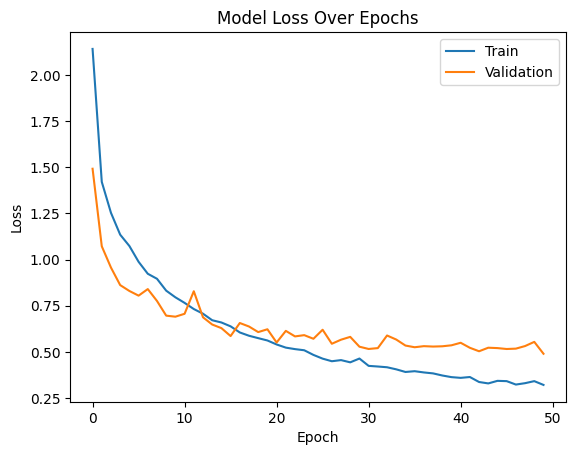

In [29]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title("Model Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

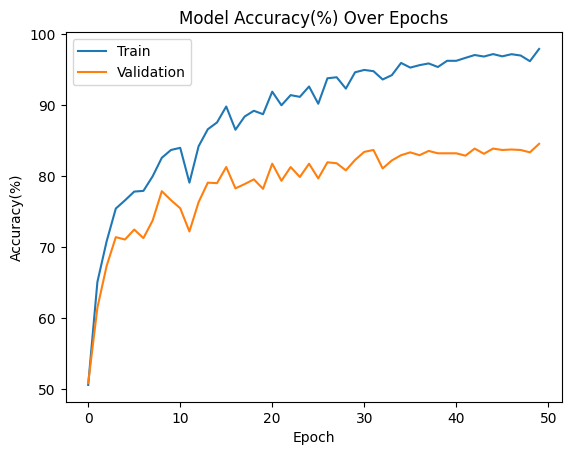

In [30]:
training_accuracy = [x.to(device='cpu') for x in training_accuracy]
validation_accuracy = [x.to(device='cpu') for x in validation_accuracy]
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy(%) Over Epochs")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

#### **Accuracy, F1 Score, and Confusion Matrix to evaluate performance on Test Dataset**

In [31]:
model.eval()
test_correct, test_samples = 0, 0
    
with torch.no_grad():
    for (data, targets) in test_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
            
        test_output = model(data)
        _, predictions = test_output.max(1)
        test_correct += (predictions == targets).sum()
        test_samples += len(targets)
model.train()

test_acc = (test_correct / test_samples) * 100
print(f"Test Accuracy: {test_acc:0.2f}%")

Test Accuracy: 85.31%


In [33]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        f1_predictions = model(data)
        f1_micro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='micro')
        f1_macro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='macro')
        f1_weighted = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='weighted')

        print(f"F1 Score (Micro): {f1_micro:0.4f}")
        print(f"F1 Score (Macro): {f1_macro:0.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:0.4f}")
        torch.cuda.empty_cache() 
    model.train()
m=0

F1 Score (Micro): 0.8531
F1 Score (Macro): 0.8524
F1 Score (Weighted): 0.8523


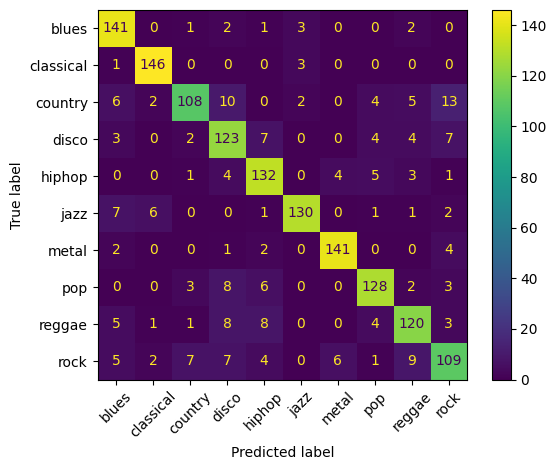

In [34]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        test_output = model(data)
        _, test_preds = test_output.max(1)

        cm = confusion_matrix(labels.to(device='cpu'), test_preds.to(device='cpu'))
        ConfusionMatrixDisplay(cm, display_labels=genres).plot()
        plt.xticks(rotation=45)
        torch.cuda.empty_cache() 
    model.train()
m=0

### **Model 3**

#### **Defining the CNN**

In [23]:
class GenreClassifier3(nn.Module):

    def __init__(self):
        #input image dim: 3 x 128 x 128
        super(GenreClassifier3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(num_features=8)
        self.pool = nn.MaxPool2d(2, 2) # 8 x 64 x 64
        
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(num_features=16)
        #pool: 16 x 32 x 32
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm3 = nn.BatchNorm2d(num_features=32)
        #pool: 32 x 16 x 16
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm4 = nn.BatchNorm2d(num_features=64)
        #pool: 64 x 8 x 8
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.norm5 = nn.BatchNorm2d(num_features=128)
        #pool: 128*4*4
        
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(128*4*4, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.norm1(self.conv1(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.norm2(self.conv2(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.norm3(self.conv3(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.norm4(self.conv4(x))))
        x = self.dropout2(x)
        x = self.pool(F.relu(self.norm5(self.conv5(x))))

        x = x.reshape(x.shape[0], -1)

        x = self.dropout1(x)
        x = self.fc1(x)
        
        return x
    

In [24]:
#Model + hyperparamters
num_epochs = 100
lr = 0.0005
#weight_decay = 1e-4
model = GenreClassifier3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
model.train()

GenreClassifier3(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): D

In [26]:
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

In [27]:
for i in range(num_epochs):
    print(f"Training EPOCH {i+1}/{num_epochs}...")
    start = time.time()

    epoch_train_loss = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        output = model(data)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()

    end1 = time.time()

    model.eval()
    train_correct, train_samples, val_correct, val_samples = 0, 0, 0, 0
    epoch_val_loss = 0
    
    with torch.no_grad():
        for (data, targets) in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            train_output = model(data)
            _, predictions = train_output.max(1)
            train_correct += (predictions == targets).sum()
            train_samples += len(targets)

        for (data, targets) in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            val_output = model(data)
            _, predictions = val_output.max(1)
            val_correct += (predictions == targets).sum()
            val_samples += len(targets)

            loss = criterion(val_output, targets)
            epoch_val_loss += loss.item()       

    model.train()

    end2 = time.time()
    
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)

    train_acc = (train_correct / train_samples) * 100
    val_acc = (val_correct / val_samples) * 100

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    print(f"EPOCH {i+1}/{num_epochs}: Training Loss={train_loss:.4f}, Validation Loss={val_loss:0.4f}, Training Accuracy={train_acc:0.2f}%, Validation Accuracy={val_acc:0.2f}%")
    print(f"EPOCH {i+1}/ {num_epochs}: Training time={(end1-start):0.2f} seconds, Accuracy Check Time={(end2-end1):0.2f} seconds")
    print(f"\n")

Training EPOCH 1/100...
EPOCH 1/100: Training Loss=1.8497, Validation Loss=3.4566, Training Accuracy=10.04%, Validation Accuracy=10.14%
EPOCH 1/ 100: Training time=39.54 seconds, Accuracy Check Time=17.10 seconds


Training EPOCH 2/100...
EPOCH 2/100: Training Loss=1.3741, Validation Loss=2.9845, Training Accuracy=18.62%, Validation Accuracy=18.41%
EPOCH 2/ 100: Training time=40.19 seconds, Accuracy Check Time=17.17 seconds


Training EPOCH 3/100...
EPOCH 3/100: Training Loss=1.2082, Validation Loss=2.3207, Training Accuracy=31.89%, Validation Accuracy=31.82%
EPOCH 3/ 100: Training time=39.32 seconds, Accuracy Check Time=21.19 seconds


Training EPOCH 4/100...
EPOCH 4/100: Training Loss=1.1046, Validation Loss=1.9854, Training Accuracy=39.64%, Validation Accuracy=39.43%
EPOCH 4/ 100: Training time=39.14 seconds, Accuracy Check Time=19.54 seconds


Training EPOCH 5/100...
EPOCH 5/100: Training Loss=1.0516, Validation Loss=1.8115, Training Accuracy=41.08%, Validation Accuracy=40.36%
EPOC

#### **Plotting graphs for loss and model accuracy (Training & Validation Datasets)**

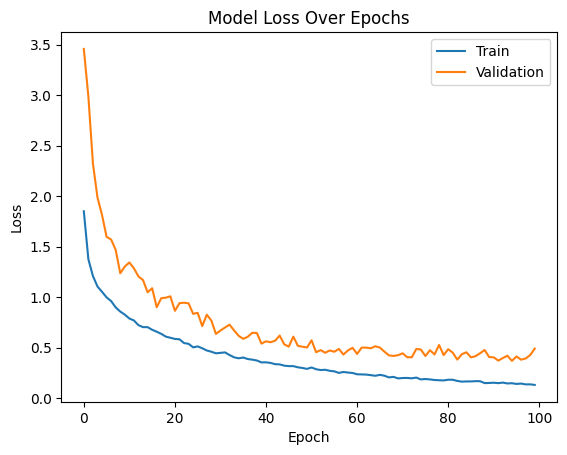

In [28]:
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title("Model Loss Over Epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

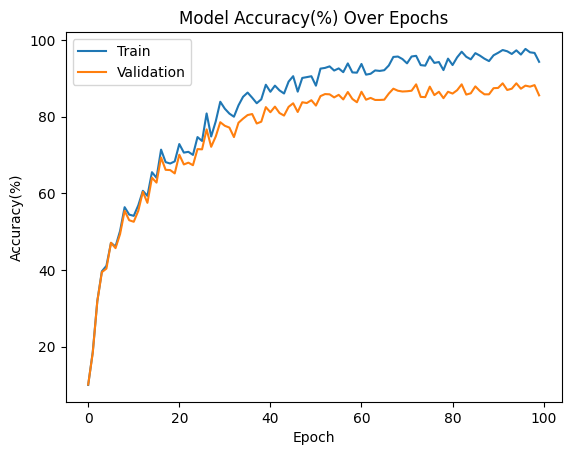

In [29]:
training_accuracy = [x.to(device='cpu') for x in training_accuracy]
validation_accuracy = [x.to(device='cpu') for x in validation_accuracy]
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title("Model Accuracy(%) Over Epochs")
plt.ylabel("Accuracy(%)")
plt.xlabel("Epoch")
plt.legend(['Train', 'Validation'])
plt.show()

#### **Accuracy, F1 Score, and Confusion Matrix to evaluate performance on Test Dataset**

In [30]:
model.eval()
test_correct, test_samples = 0, 0
    
with torch.no_grad():
    for (data, targets) in test_loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
            
        test_output = model(data)
        _, predictions = test_output.max(1)
        test_correct += (predictions == targets).sum()
        test_samples += len(targets)
model.train()

test_acc = (test_correct / test_samples) * 100
print(f"Test Accuracy: {test_acc:0.2f}%")

Test Accuracy: 84.58%


In [42]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        f1_predictions = model(data)
        f1_micro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='micro')
        f1_macro = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='macro')
        f1_weighted = multiclass_f1_score(f1_predictions, labels, num_classes=10, average='weighted')

        print(f"F1 Score (Micro): {f1_micro:0.4f}")
        print(f"F1 Score (Macro): {f1_macro:0.4f}")
        print(f"F1 Score (Weighted): {f1_weighted:0.4f}")
        torch.cuda.empty_cache() 
    model.train()
m=0

F1 Score (Micro): 0.8458
F1 Score (Macro): 0.8438
F1 Score (Weighted): 0.8438


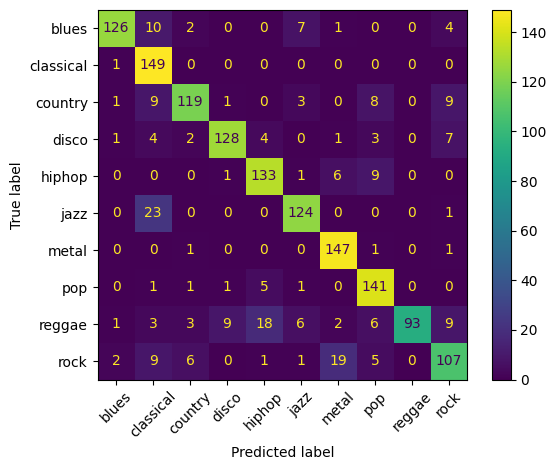

In [41]:
model.eval()
temp_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

with torch.no_grad():
    for data, labels in temp_loader:
        data = data.to(device=device)
        labels = labels.to(device=device)
    
        test_output = model(data)
        _, test_preds = test_output.max(1)

        cm = confusion_matrix(labels.to(device='cpu'), test_preds.to(device='cpu'))
        ConfusionMatrixDisplay(cm, display_labels=genres).plot()
        plt.xticks(rotation=45)
        torch.cuda.empty_cache() 
    model.train()
m=0

In [39]:
import gc
gc.collect()

2441